# Homework 2 - Filtrage numérique - Elec 4 - Romain Cocogne


Vous êtes  ingénieur audio, et vous recevez un multiplex audio formé de 12 canaux.  Chaque canal contient un signal codé en '.wav' à 44100 ksps, et donc de largeur 44100 Hz, et la fréquence centrale de chacune des bandes est de $k$ 44100 kHz, où $k=[0 .. 11]$.  La largeur de bande totale est donc de 1036350/2 kHz.
On vous demande de récupérer le canal $x$, en utilisant, outre les techniques de filtrage numérique, un banc de filtres.

Vous choisirez $x$ comme étant le jour de votre naissance modulo 9 (ou modulo 9 +1), de telle sorte que le numéro de canal soit impair.




Dans un deuxième temps, vous remplacerez échangerez les contenus du canal $x$ et du  canal $y=10$.  Pour ce faire, vous utiliserez également un banc de filtres polyphases.

Vous rendrez un Notebook jupyter, comprenant les différents codes, avec :
<ol>

<li> la démodulation par filtrage ``simple'' ;
<li> la démodulation par filtrage polyphase ;
<li> une instruction qui ``joue'' la musique du canal $x$ ;
<li> le morceau de code qui démodule et ``joue'' la musique du canal 10 ;
<li> le code qui échange les canaux $x$ et 10.
</ol>



## choix du canal

In [1]:
# generation de x:
x = 29%9+1
print("CANAL: ",x)

CANAL:  3


In [2]:
##### Préparation - bibliothèques et variables principales

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
from scipy.io import savemat

import IPython

fs=44100
temps = 5    # on prend les signaux sur 30 secondes
channels=12
y=np.zeros((channels,fs*temps))              # un tableau avec les 24 canaux (temporels)
yup=np.zeros((2*fs*temps*channels))          # un tableau pour stocker un canal suréchantillonné par 2*channels
ymux=np.zeros((2*fs*temps*channels))         # un tableau pour stocker le signal multiplexé
numtaps=301                                  # l'ordre des filtres

## Recuperation du fichier

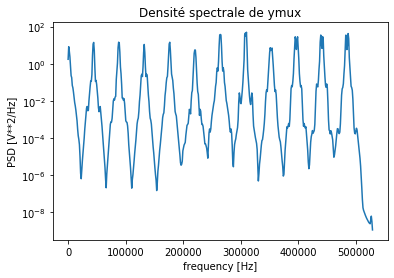

In [3]:
ymux=np.load("muxedsignals.npy")

f, Pxx2_den = signal.welch(ymux, 2*fs*channels, nperseg=1024)
plt.semilogy(f, Pxx2_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Densité spectrale de ymux')
plt.show()

## Démultiplexage "naïf"

Dans cette partie, je démultiplexe un canal particulier ($i$) par filtrage simple, suivi d'un sous-échantillonnage.

In [4]:
def show_channel (i,ym = ymux):
    
    print(' CANAL NUMERO :',i)

    #design et affichage du filtre
    H = signal.firwin(2*numtaps+1, np.array([fs/2]), window=('kaiser',14),scale=False, fs=2*fs*channels, pass_zero='lowpass')                            # design du filtre
    
    Om, Hk = signal.freqz(H)
    plt.figure(figsize=(10, 3))
    plt.plot(Om*fs*channels/np.pi, 20 * np.log10(abs(Hk)), label='filtre')
    plt.title('Filtre passe bas')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
    plt.axis([0, fs*channels, -180, 3])
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    
    #demultiplexage du canal i: on passe en bande de base, filtre avec un passe bas, puis recentre a la bonne frequence
    yjour = (ym*np.cos(np.pi*2*(2*channels-i)/(2*channels)*np.arange(ym.size)+np.pi/2*i))
    yjour=np.convolve(H,yjour)                          
    yjour = yjour*np.cos(np.pi*2*(2*channels-i)/(2*channels)*np.arange(yjour.size))
    
    #affichage des spectres
    f, Pxx_den = signal.welch(yjour, 2*fs*channels,window=('kaiser',14), nperseg=1024)
    f, Pxx2_den = signal.welch(ym, 2*fs*channels, nperseg=1024)
    
    plt.figure(figsize=(10,3))
    plt.plot(f, 10 * np.log10((Pxx_den)), label="canal "+str(i))
    plt.plot(f, 10 * np.log10((Pxx2_den)), label="ymux")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Densité spectrale du canal et de ymux')
    plt.legend(loc=4)
    plt.show()

    #sous echantillonnage du canal i
    yjour = yjour[::2*channels]
    f, Pxx_den = signal.welch(yjour, fs/channels/2, nperseg=1024)
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Densité spectrale du signal   après démultiplexage')
    plt.show()
    
    #on retourne le canal sous echantillonné pour l'écoute
    return yjour

## Démodulation et lecture du canal x

 CANAL NUMERO : 3


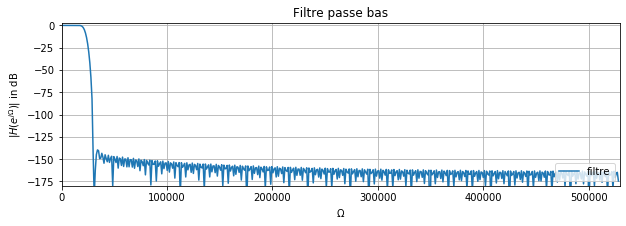

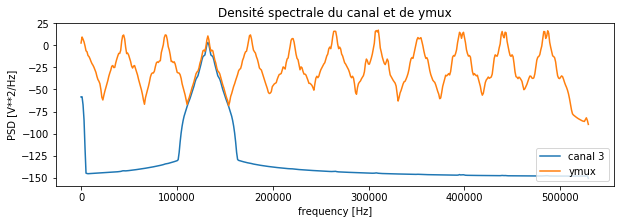

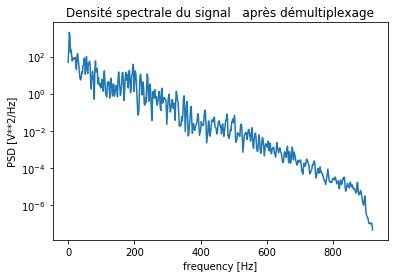

In [5]:
IPython.display.Audio(show_channel(x), rate=fs)

## Filtrage par filtre polyphase

Ici, on définit le filtre polyphase $H_i(z)$ dans *h_poly*.  Ensuite, on fait le filtrage polyphase avec sous-échantillonnage dans *poly_convolve_down*.

In [6]:
#creation du banc de filtres
def h_poly(H,M):
    Hpoly = np.zeros((M,int(H.size/M)))
    for i in range(M):
        Hpoly[i,::] = H[i::M]
    return Hpoly


def poly_convolve_down(x,H,M):
    # on ajuste la taille du filtre et de x pour etre un multiple de M
    if H.size % M != 0:
        H = np.append(H, np.zeros((M - H.size % M,)))
    if x.size % M != 0:
        x = np.append(x, np.zeros((M - x.size % M,)))
    
    #chargement du banc de filtres
    Hpoly=h_poly(H,M)
    
    #on cree un tableau qui tout les filtrages
    p= np.zeros((M,int((x.size+H.size)/M)))
    
    #on traite le premier cas a part 
    p[0,:-1] = np.convolve(x[::M], Hpoly[0])
    for i in range(1,M):
        p[i,1:]= np.convolve(x[M-i::M],Hpoly[i]) #le decalage de x est inversé 
    
    #décommenter ces lignes si on veut observer le canal sur échantillonné
    #out = np.zeros (p.shape[1]*M)
    #out[::M]=np.sum(p, axis=0)
    #return out 
    
    return np.sum(p, axis=0)

def poly_convolve_full(x,H,M):
    # on ajuste la taille du filtre et de x pour etre un multiple de M
    if H.size % M != 0:
        H = np.append(H, np.zeros((M - H.size % M,)))
    if x.size % M != 0:
        x = np.append(x, np.zeros((M - x.size % M,)))

    Hpoly = np.zeros((M,H.size))
    out = np.zeros(int((x.size+H.size))-1)
    for i in range(M):
        Hpoly[i,::M] = H[i:H.size+i:M]
        out+= np.convolve(x,Hpoly[i])
        x = np.concatenate([[0],x[:-1:]])
    return out


In [7]:
def show_channel_poly(i,ym=ymux):
    
    print(' CANAL NUMERO :',i)
    
    #design et affichage du filtre (meme que filtrage naif)
    h= signal.firwin(2*numtaps+1, np.array([fs/2]), window=('kaiser',14),scale=False, fs=2*fs*channels, pass_zero='lowpass')
    Om, Hk = signal.freqz(h)
    plt.figure(figsize=(10, 3))
    plt.plot(Om*fs*channels/np.pi, 20 * np.log10(abs(Hk)), label='filtre')
    plt.title('Filtre passe bas')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
    plt.axis([0, fs*channels, -180, 3])
    plt.legend(loc=4)
    plt.grid()
    plt.show()

    #filtrage par polyphase. comme on sous echantillonne dans le filtrage, pas besoin de revenir sur la bonne frequence avec un cosinus
    ypoly = ym*np.cos(np.pi*2*(2*channels-i)/(2*channels)*np.arange(ym.size)+np.pi/2*i)
    ypoly=poly_convolve_down(ypoly,h,2*channels)*channels
    
    #affichage du spectre
    f, Pxx_den = signal.welch(ypoly, fs/channels/2, nperseg=1024)
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Densité spectrale du signal   après démultiplexage')
    plt.show()
        
    return ypoly


 CANAL NUMERO : 3


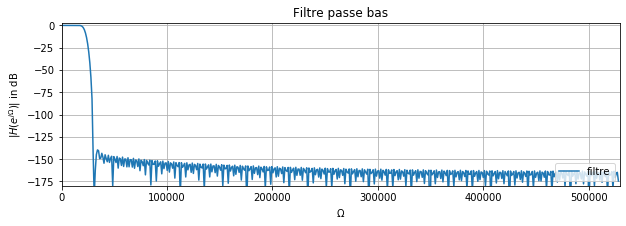

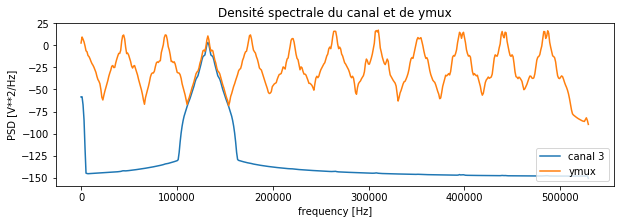

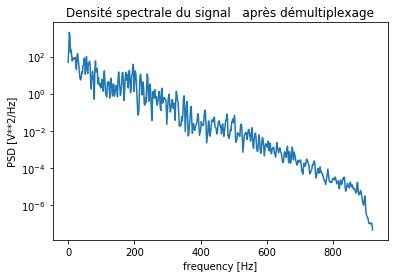

In [8]:
canal_x_naif=show_channel(x)
IPython.display.Audio(canal_x_naif, rate=fs)

 CANAL NUMERO : 3


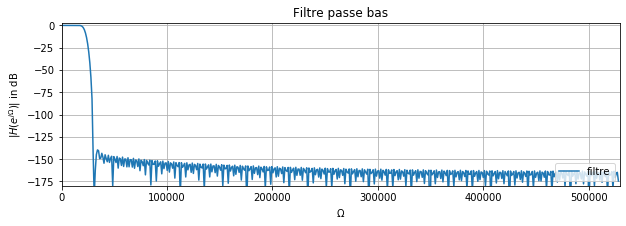

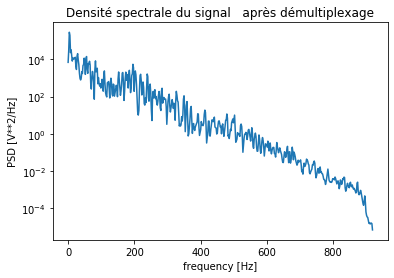

In [9]:
canal_x_poly=show_channel_poly(x)
IPython.display.Audio(canal_x_poly, rate=fs)

## Echange de canaux

In [10]:
def exchange(ym,x,y, do_poly=0):
    #design du premier filtre qui recupère les 2 canaux
    h= signal.firwin(numtaps, np.array([fs/2]), window=('kaiser',14),scale=False, fs=2*fs*channels, pass_zero='lowpass')                            # design du filtre
    Om, Hk = signal.freqz(h)
    plt.figure(figsize=(10, 3))
    plt.plot(Om*fs*channels/np.pi, 20 * np.log10(abs(Hk)), label='filtre')
    plt.title('Filtre passe bas')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
    plt.axis([0, fs*channels, -180, 3])
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    
    #filtrage des 2 canaux par la methode naive. on en profite pour inverser les 2 frequences quand on quitte la bande de base
    if (not do_poly):
        y1 = ym*np.cos(np.pi*2*(2*channels-x)/(2*channels)*np.arange(ym.size)-np.pi/2*x)
        y1 = np.convolve(h,y1)
        y1 = y1*np.cos(np.pi*2*(2*channels-y)/(2*channels)*np.arange(y1.size)-np.pi/2*y)
    
        y2 = ym*np.cos(np.pi*2*(2*channels-y)/(2*channels)*np.arange(ym.size)-np.pi/2*y)
        y2 = np.convolve(h,y2)
        y2 = y2*np.cos(np.pi*2*(2*channels-x)/(2*channels)*np.arange(y2.size)-np.pi/2*x)
    
    #filtrage pas la methode polyphase. Pas très efficace par rapport a la methode naive
    else:
        y1 = ym*np.cos(np.pi*2*(2*channels-x)/(2*channels)*np.arange(ym.size)-np.pi/2*x)
        y1 = poly_convolve_full(y1,h,2*channels)
        y1 = y1*np.cos(np.pi*2*(2*channels-y)/(2*channels)*np.arange(y1.size)-np.pi/2*y)
    
        y2 = ym*np.cos(np.pi*2*(2*channels-y)/(2*channels)*np.arange(ym.size)-np.pi/2*y)
        y2 = poly_convolve_full(y2,h,2*channels)
        y2 = y2*np.cos(np.pi*2*(2*channels-x)/(2*channels)*np.arange(y2.size)-np.pi/2*x)
    
    #deux coupe bande pour enlever les canaux deja presents dans ymux
    hxy = signal.firwin(2*numtaps+1, np.array([fs*x-fs/2,fs*x+fs/2,fs*y-fs/2,fs*y+fs/2]), window=('kaiser',14),scale=False, fs=2*fs*channels, pass_zero='bandstop')
    Om, Hkxy = signal.freqz(hxy)
    plt.figure(figsize=(10, 3))
    plt.plot(Om*fs*channels/np.pi, 20 * np.log10(abs(Hkxy)), label='filtre de x et y')
    plt.title('Filtre coupe bandes')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
    plt.axis([0, fs*channels, -180, 3])
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    
    f, Pxx0_den = signal.welch(ym, 2*fs*channels,window=('kaiser',14), nperseg=1024)
    
    #filtrage 
    if(not do_poly):
        ym = np.convolve(ym,hxy)
    else:
        ym = poly_convolve_full(ym,hxy,2*channels)
    
    f, Pxx_den = signal.welch(ym, 2*fs*channels,window=('kaiser',14), nperseg=1024)
    plt.figure(figsize=(10,3))
    plt.plot(f, 10 * np.log10((Pxx_den)), label="ymux filtré")
    plt.plot(f, 10 * np.log10((Pxx0_den)), label="ymux non filtré")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Densité spectrale de ymux avant et apres filtrage')
    plt.legend(loc=4)
    plt.show()
    
    #ajout des canaux inversés
    ym[:y1.size:]+=y1
    ym[:y2.size:]+=y2
    
    f, Pxx2_den = signal.welch(ym, 2*fs*channels,window=('kaiser',14), nperseg=1024)
    plt.figure(figsize=(10,3))
    plt.plot(f, 10 * np.log10((Pxx0_den)), label="avant")
    plt.plot(f, 10 * np.log10((Pxx2_den)), label="apres")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Densité spectrale de ymux avant et apres inversion des canaux')
    plt.legend(loc=4)
    plt.show()
    
    return ym
    

 CANAL NUMERO : 3


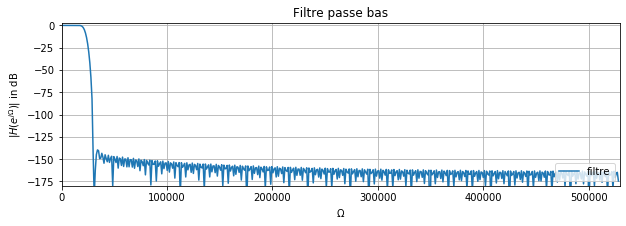

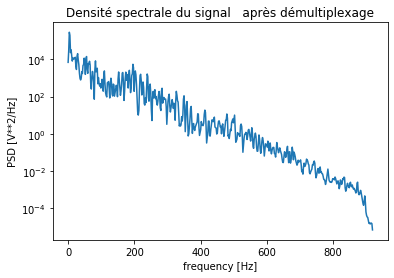

In [11]:
x_origin=show_channel_poly(x)
IPython.display.Audio(x_origin, rate=fs)

 CANAL NUMERO : 10


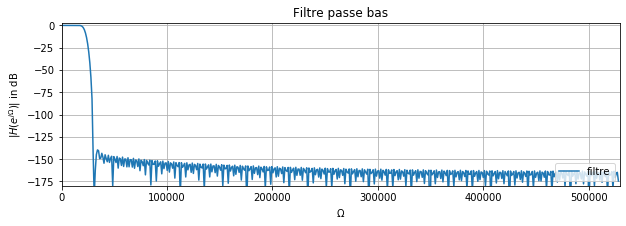

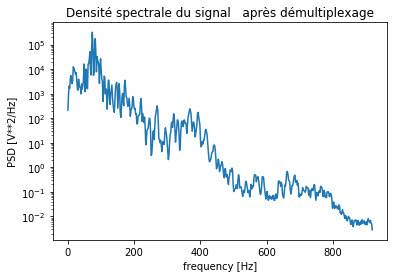

In [12]:
IPython.display.Audio(show_channel_poly(10), rate=fs)

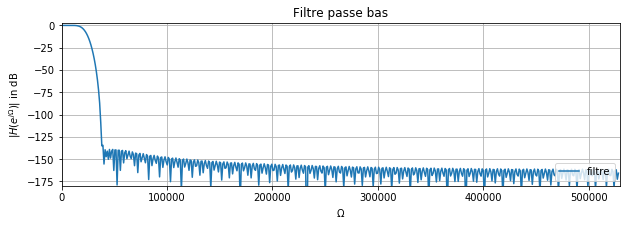

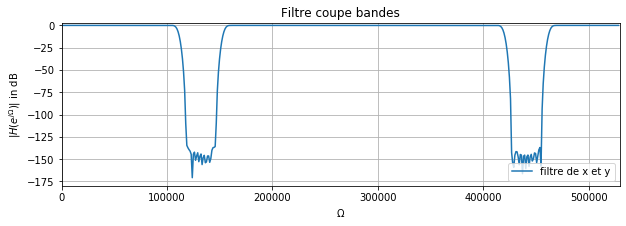

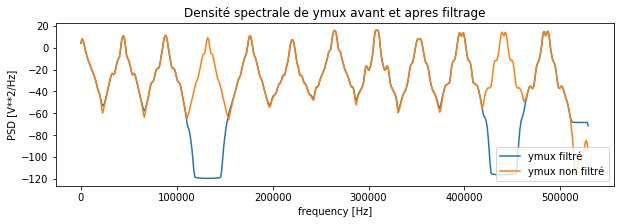

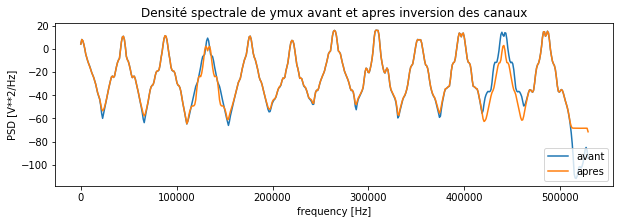

In [13]:
ym = exchange(ymux,x,10, do_poly=0)

 CANAL NUMERO : 3


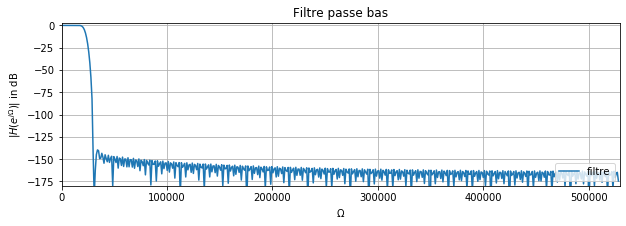

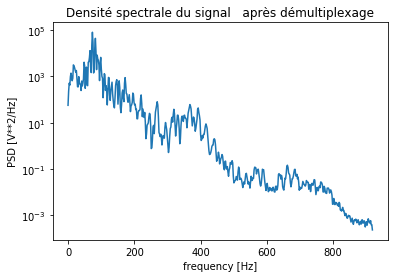

In [14]:
IPython.display.Audio(show_channel_poly(x,ym), rate=fs)

 CANAL NUMERO : 10


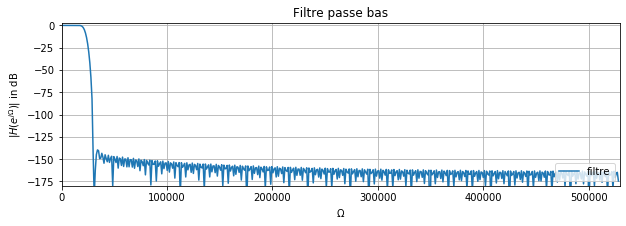

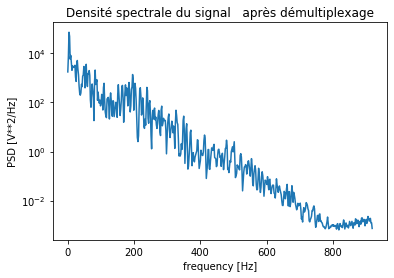

In [15]:
x_inv=show_channel_poly(10,ym)
IPython.display.Audio(x_inv, rate=fs)

Après écoute, on voit bien que les 2 canaux sont inversé.

### Calcul du SNR du a l'inversion du canal x

SNR :  -9.077531322249696


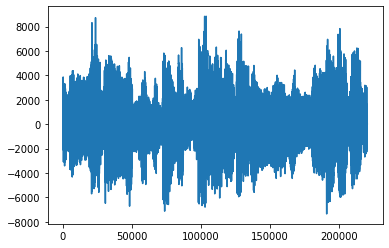

In [42]:
lmin=np.min([x_origin.size,x_inv.size])
diff=(x_origin[0:lmin:])-(x_inv[0:lmin:])
print('SNR : ', 20*np.log10(np.linalg.norm(x_inv)/np.linalg.norm(diff)))
plt.plot((diff))
plt.show()

On remarque que meme si la différence ne s'entend pas à l'oreille, l'opération d'echange des canaux a ajouté beaucoup de bruit. Il faut donc faire attention à ne pas réitérer l'opération un grand nombre de fois.